<img src='./img/egu21_logo.png' alt='Logo EU Copernicus EUMETSAT' align='left' width='25%'></img><img src='./img/atmos_logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='65%'></img></span>

<br>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./03_CAMS_European_air_quality_forecast_dust_concentration_load_browse.ipynb"><< 03 - CAMS European Air Quality Forecast - Dust</a><span style="float:right;"><a href="./05_Metop-ABC_GOME-2_AAI_L3_load_browse.ipynb">05 - Metop-ABC GOME-2 AAI Level 3 >></a></span>

<hr>

# Sentinel-5P TROPOMI - Ultraviolet Aerosol Index (AI) - Level 2

A precursor satellite mission, Sentinel-5P aims to fill in the data gap and provide data continuity between the retirement of the Envisat satellite and NASA's Aura mission and the launch of Sentinel-5. The Copernicus Sentinel-5P mission is being used to closely monitor the changes in air quality and was launched in October 2017.

Sentinel-5P Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/).

Sentinel-5P carries the `TROPOMI` instrument, which is a spectrometer in the UV-VIS-NIR-SWIR spectral range. `TROPOMI` provides measurements on:
* `Ozone`
* `NO`<sub>`2`</sub>
* `SO`<sub>`2`</sub>
* `Formaldehyde`
* `Aerosol`
* `Carbonmonoxide`
* `Methane`
* `Clouds`

The subsequent example introduces you to Sentinel-5P data in general and the Aerosol Index retrieved from Sentinel-5P TROPOMI in specific. The Aerosol Index (AI) is a qualitative index indicating the presence of elevated layers of aerosols with significant absorption. The main aerosol types that cause signals detected in the AI are desert dust, biomass burning and volcanic ash plumes. An advantage of the AI is that it can be derived for clear as well as (partly) cloudy ground pixels.


#### Module outline:
* [1 - Load and browse 'Sentinel-5P TROPOMI Aerosol Index Level 2' data](#load_browse_s5p)
* [2 - Retrieve the variable 'Aerosol index from 354 and 388 nm' as xarray.DataArray](#data_retrieve_s5p)
* [3 - Visualize 'Sentinel-5P TROPOMI aerosol index from 388 and 354 nm'](#visualize_s5p)
* [4 - Create a geographical subset for Europe](#subset_s5p)

<hr>

##### Load required libraries

In [27]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

##### Load helper functions

In [3]:
%run ./functions.ipynb

<hr>

### <a id='load_browse_s5p'></a>Load and browse `Sentinel-5P TROPOMI Aerosol Index Level 2` data

A Sentinel-5P TROPOMI Aerosol Index Level 2 file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P TROPOMI variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load a `netCDF` file with the `open_dataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group

Let us load a Sentinel-5P TROPOMI data file as `xarray.Dataset` from 22 February 2021 and inspect the data structure:

In [28]:
file = xr.open_dataset('./eodata/sentinel5p/ai/2021/02/22/S5P_OFFL_L2__AER_AI_20210222T120850_20210222T135020_17424_01_010400_20210224T015156.nc', group='PRODUCT')
file



<xarray.Dataset>
Dimensions:                          (corner: 4, ground_pixel: 450, scanline: 4173, time: 1)
Coordinates:
  * scanline                         (scanline) float64 0.0 1.0 ... 4.172e+03
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
  * time                             (time) datetime64[ns] 2021-02-22
  * corner                           (corner) float64 0.0 1.0 2.0 3.0
    latitude                         (time, scanline, ground_pixel) float32 ...
    longitude                        (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                       (time, scanline) datetime64[ns] ...
    time_utc                         (time, scanline) object ...
    qa_value                         (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388            (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380            (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388_precision  (time, scanline, ground_pixel) float32 ...
    aerosol_index_340_380_precision  (time, scanline, ground_pixel) float32 ...

<br>

You see that the loaded data object contains of four dimensions and seven data variables:
* **Dimensions**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`


* **Data variables**:
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `qa_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data).
  * `aerosol_index_354_388`: Aerosol index from 354 and 388 nm
  * `aerosol_index_340_380`: Aerosol index from 340 and 380 nm
  * `aerosol_index_354_388_precision`: Precision of aerosol index from 354 and 388 nm
  * `aerosol_index_340_380_precision`: Precision of aerosol index from 340 and 380 nm

<br>

### <a id='data_retrieve_s5p'></a>Retrieve the variable `Aerosol index from 354 and 388 nm` as xarray.DataArray

You can specify one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `aerosol_index_354_388` is the 'Aerosol index from 354 and 388 nm' and has three dimensions, `time`, `scanline` and `ground_pixel` respectively.

In [30]:
ai = file['aerosol_index_354_388']
ai

<xarray.DataArray 'aerosol_index_354_388' (time: 1, scanline: 4173, ground_pixel: 450)>
[1877850 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2021-02-22
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                   1
    proposed_standard_name:  ultraviolet_aerosol_index
    comment:                 Aerosol index from 388 and 354 nm
    long_name:               Aerosol index from 388 and 354 nm
    radiation_wavelength:    [354. 388.]
    ancillary_variables:     aerosol_index_354_388_precision

You can retrieve the array values of the variable with squared brackets: `[:,:,:]`. One single time step can be selected by specifying one value of the time dimension, e.g. `[0,:,:]`.

In [32]:
ai_2202 = ai[0,:,:]
ai_2202

<xarray.DataArray 'aerosol_index_354_388' (scanline: 4173, ground_pixel: 450)>
[1877850 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2021-02-22
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                   1
    proposed_standard_name:  ultraviolet_aerosol_index
    comment:                 Aerosol index from 388 and 354 nm
    long_name:               Aerosol index from 388 and 354 nm
    radiation_wavelength:    [354. 388.]
    ancillary_variables:     aerosol_index_354_388_precision

<br>

Additionally, you can save the attributes `units` and `longname`, which you can make use of when visualizing the data.

In [33]:
longname = ai_2202.long_name
units = ai_2202.units

longname, units

('Aerosol index from 388 and 354 nm', '1')

<br>

### <a id='visualize_s5p'></a>Visualize `Sentinel-5P TROPOMI aerosol index from 388 and 354 nm`

The next step is to visualize the dataset. You can use the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh), which makes use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [4]:
?visualize_pcolormesh

Signature:
visualize_pcolormesh(
    data_array,
    longitude,
    latitude,
    projection,
    color_scale,
    unit,
    long_name,
    vmin,
    vmax,
    set_global=True,
    lonmin=-180,
    lonmax=180,
    latmin=-90,
    latmax=90,
)
Docstring:
Visualizes a xarray.DataArray with matplotlib's pcolormesh function.

Parameters:
    data_array(xarray.DataArray): xarray.DataArray holding the data values
    longitude(xarray.DataArray): xarray.DataArray holding the longitude values
    latitude(xarray.DataArray): xarray.DataArray holding the latitude values
    projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
    color_scale(str): string taken from matplotlib's color ramp reference
    unit(str): the unit of the parameter, taken from the NetCDF file if possible
    long_name(str): long name of the parameter, taken from the NetCDF file if possible
    vmin(int): minimum number on visualisation legend
    vmax(int): maximum number on visualisation

You can make use of the variables we have defined above:
- `units`
- `long_name`
- `latitude`
- `longitude`

Additionally, you can specify the color scale and minimum and maxium data values.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Aerosol index from 388 and 354 nm 2021-02-22T00:00:00.000000000'}>)

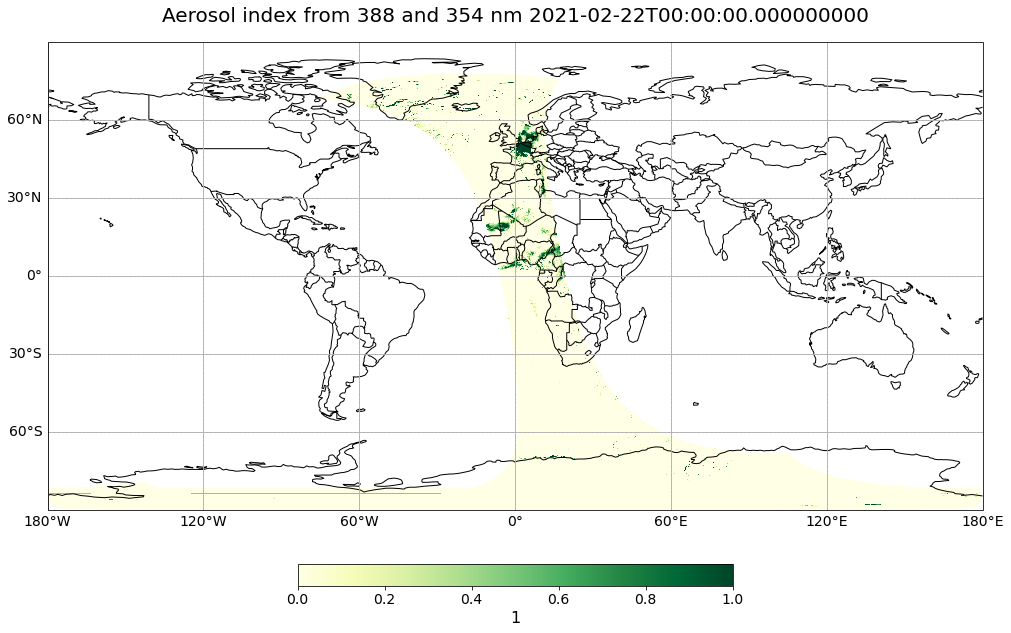

In [35]:
visualize_pcolormesh(data_array=ai_2202,
                     longitude=ai_2202.longitude,
                     latitude=ai_2202.latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='YlGn',
                     unit=units,
                     long_name=longname + ' ' + str(ai_2202.time.data),
                     vmin=0, 
                     vmax=1,
                     lonmin=-180,
                     lonmax=180,
                     latmin=-90,
                     latmax=90,
                     set_global=True)

<br>

### <a id='subset_s5p'></a>Create a geographical subset for Europe

The map above shows the aerosol index of one footprint along the entire latitude range. Let us create a geographical subset for Europe, in order to better analyse the Saharan dust event which occured in February 2021 over Europe.

For geographical subsetting, you can use the function [generate_geographical_subset](./functions.ipynb#generate_geographical_subset). You can use `?generate_geographical_subset` to open the docstring in order to see the function's keyword arguments.

In [47]:
?generate_geographical_subset

Signature:
generate_geographical_subset(
    xarray,
    latmin,
    latmax,
    lonmin,
    lonmax,
    reassign=False,
)
Docstring:
Generates a geographical subset of a xarray.DataArray and if kwarg reassign=True, shifts the longitude grid 
from a 0-360 to a -180 to 180 deg grid.

Parameters:
    xarray(xarray.DataArray): a xarray DataArray with latitude and longitude coordinates
    latmin, latmax, lonmin, lonmax(int): lat/lon boundaries of the geographical subset
    reassign(boolean): default is False
    
Returns:
    Geographical subset of a xarray.DataArray.
File:      ~/<ipython-input-2-0fa94af16892>
Type:      function


Define the bounding box information for Europe

In [36]:
latmin = 28.
latmax = 71.
lonmin = -22.
lonmax = 43

<br>

Now, let us apply the function [generate_geographical_subset](./functions.ipynb#generate_geographcial_subset) to subset the `ai_2202` xarray.DataArray. Let us call the new `xarray.DataArray` `ai_2202_subset`.

In [37]:
ai_2202_subset = generate_geographical_subset(xarray=ai_2202, 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
ai_2202_subset

<xarray.DataArray 'aerosol_index_354_388' (scanline: 912, ground_pixel: 450)>
array([[        nan,         nan,         nan, ..., -0.41337126,
        -0.43075165, -0.47016436],
       [        nan,         nan,         nan, ..., -0.43842795,
        -0.4553739 , -0.44535434],
       [        nan,         nan,         nan, ..., -0.4748092 ,
        -0.5152617 , -0.4655524 ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 2.787e+03 2.788e+03 ... 3.697e+03 3.698e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2021-02-22
    latitude      (scanline, ground_pixel) float32 22.487244 ... 71.67947
    longitude     (scanline, ground_pixel) float32 -11.969013 ... 14.185131
Attributes:
    units:                   1
    proposed_standard_name:  ultraviolet_aerosol_index
    comment:                 Aerosol index from 388 and 354 nm
    long_name:               Aerosol index from 388 and 354 nm
    radiation_wavelength:    [354. 388.]
    ancillary_variables:     aerosol_index_354_388_precision

<br>

Let us visualize the subsetted `xarray.DataArray` again. This time, you set the `set_global` kwarg to `False` and you specify the longitude and latitude bounds specified above.

Additionally, in order to have the time information as part of the title, we add the string of the datetime information to the `longname` variable: `longname + ' ' + str(ai_2202.time.data)`.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Aerosol index from 388 and 354 nm 2021-02-22T00:00:00.000000000'}>)

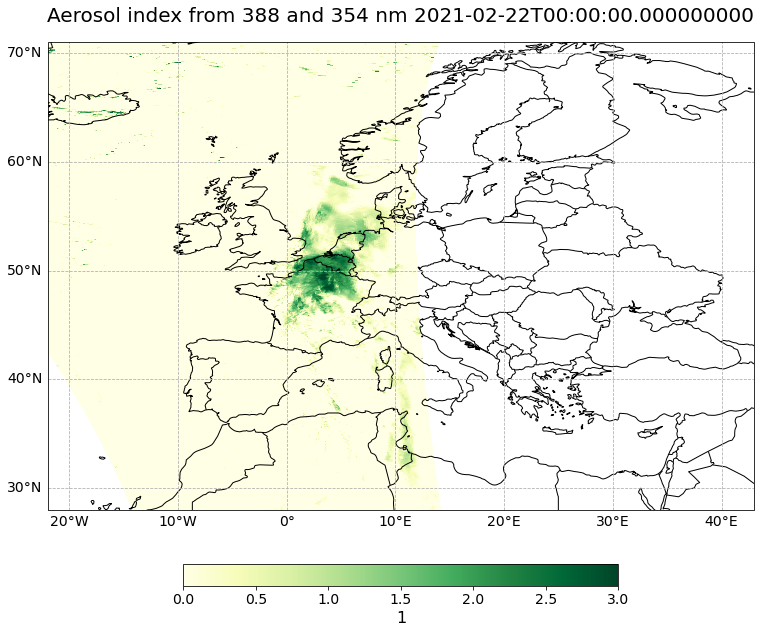

In [38]:
visualize_pcolormesh(data_array=ai_2202_subset,
                     longitude=ai_2202_subset.longitude,
                     latitude=ai_2202_subset.latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='YlGn',
                     unit=units,
                     long_name=longname + ' ' + str(ai_2202_subset.time.data),
                     vmin=0, 
                     vmax=3,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

<br>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./03_CAMS_European_air_quality_forecast_dust_concentration_load_browse.ipynb"><< 03 - CAMS European Air Quality Forecast - Dust</a><span style="float:right;"><a href="./05_Metop-ABC_GOME-2_AAI_L3_load_browse.ipynb">05 - Metop-ABC GOME-2 AAI Level 3 >></a></span>

<hr>

<img src='../../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>
<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.